# Konvoluční síť pro klasifikaci obrázků

Cílem tohoto cvičení je vytvoření jednoduché konvoluční sítě pro klasifikaci obrázků do 10 tříd.

## Dataset

Cifar10 je datová sada o 50 000 barevných tréninkových obrázků 32x32 a 10 000 testovacích obrázků označených v 10 kategoriích. 

Další informace naleznete na https://www.cs.toronto.edu/~kriz/cifar.html

## Třídy
- 0 	airplane
- 1 	automobile
- 2 	bird
- 3 	cat
- 4 	deer
- 5 	dog
- 6 	frog
- 7 	horse
- 8 	ship
- 9 	truck

# Načtení datasetu
Opět se jedná o známý dataset, proto je v keras připravená funkce cifar10.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Načtené třídy si pojmenujeme podle známého pořadí.

In [ ]:
class_names=["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(class_names)

# Průzkum dat
O datech zatím nic nevíme, proto se na ně podíváme.

Velikosti numpy polí nám ukazuje:
* Trénovacích dat je 50000
* Testovacích dat je 10000
* Obrázky jsou veliké 32x32
* Obrázky jsou barevné, protože máme 3 kanály RGB

In [ ]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

Můžeme si vypsat surová data pro první obrázek. Vidíme, že hodnoty jsou uloženy v datovém typu uint(8), který má rozsah 0..255.

In [ ]:
X_train[0]

Obrázků by mělo být 10 tříd, tak se podíváme na unikátní hodnoty matic Y_train a Y_test. Chceme, aby v nich byly zastoupeny všechny třídy.

In [ ]:
print(np.unique(y_train))
print(np.unique(y_test))

Dobrý dataset je vyvážený. V každé třídě by měl být podobný počet obrázků.

Vykreslíme si graf četnosti tříd.

In [ ]:
sns.displot(y_train)

In [ ]:
sns.displot(y_test)

# Vizualizace dat
Jsou to obrázky. Proto si zobrazíme jejich náhled.

Vidíme, že obrázky jsou hodně malé a u některých je problém i u člověka určit, co na nich je.

In [ ]:
def show_images (images, labels, rows=6, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    plt.subplots_adjust(bottom=0)
    
    for idx in range (0, rows * cols):
        ridx=idx//cols
        cidx=idx % cols        
        ax= axes[ridx, cidx]
        ax.axis("off")
        ax.imshow(images[idx])
        label = class_names[labels[idx][0]]
        ax.set_title(f"{label}")        

In [ ]:
show_images(X_train, y_train, 3, 10)

# Příprava dat
Rozsah hodnot je 0..255. Datový typ uint8.

Neuronové sítě lépe pracují se standardizovanými hodnotami okolo 0.

Proto změníme datový typ na float32 a data standardizujeme vydělení 255. Tím získáme rozsah 0..1

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255
X_test = X_test / 255

Kontrolní zobrazení surových dat.

In [ ]:
X_train[0]

Výstupních kategorie ve vstupních datech opět uloženy jako číslo třídy.

Pro neuronové síť budeme chtít mít výstupní data v podobě vektoru. 

Provedeme binární encoding.

In [ ]:
from keras.utils import to_categorical
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Kontrolní zobrazení výstupních dat.

In [ ]:
y_train[0]

# Konvoluční neuronová síť pomocí Keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

Konvoluční neuronová síť je dopředná / sekvenční.

In [ ]:
model = Sequential()

Na rozdíl od klasických sítí, konvoluční sítě pracují s prostorovou souvislostí vstupních dat. Proto vstupní data nebudeme převádět na jednorozměrný vektor, ale ponecháme je ve formě matice.

In [ ]:
model.add(Input(shape=(32,32,3)))

Přidáme první konvoluční vrstvu.
* filters     - 32 konvolučních filtrů
* kernel_size - velikost konvolučních filtrů 3 x 3
* padding     - zarovnání same vede k rovnoměrnému vyplňování vlevo/vpravo nebo nahoru/dolů od vstupu
* activation  - aktivační funkce ReLU

In [ ]:
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))

Přidáme další konvoluční vrstvu.

In [ ]:
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))

Za dvojici konvolučních vrstev následuje maxpolling vrstva.

Ta redukuje velikost matic pomocí poolu 2x2.

In [ ]:
model.add(MaxPooling2D(pool_size=(2,2)))

Aby naše neuronová síť byla více odolná proti overfittingu, přidáme Dropout vrstvu.

Vrstva Dropout náhodně nastavuje vstupní neurony na 0, což pomáhá zabránit nadměrnému přizpůsobení sítě trénovacím datům.

Vstupy, které nejsou nastaveny na 0, se škálují o 1 / (1 - rate) tak, aby se součet všech vstupů nezměnil.

In [ ]:
model.add(Dropout(0.3))

Pak se přidáme druhý blok konvolučních, maxpooling a dropout vrstev.

In [ ]:
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

Třetí blok

In [ ]:
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

Po sérii konvolučních vrstev je potřeba vystavět část sítě, která bude hodnoty převádět na kategorie.

Vrstva Flatten dosavadní vícerozměrná pole zploští na 1 rozměr.

In [ ]:
model.add(Flatten())

Klasifikační část s plně propojenými vrstvami s aktivačními funkce ReLU.

In [ ]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

Poslední vrstva má 10 výstupních neuronů, protože máme 10 tříd obrázků.

Používá se aktivační funkce softmax, která hodnoty převádí na pravděpodobnosti.

In [ ]:
model.add(Dense(num_classes, activation='softmax')) 

Model si zobrazíme.

In [ ]:
model.summary()

In [ ]:
from keras_visualizer import visualizer 
visualizer(model, file_format='png', view=True)

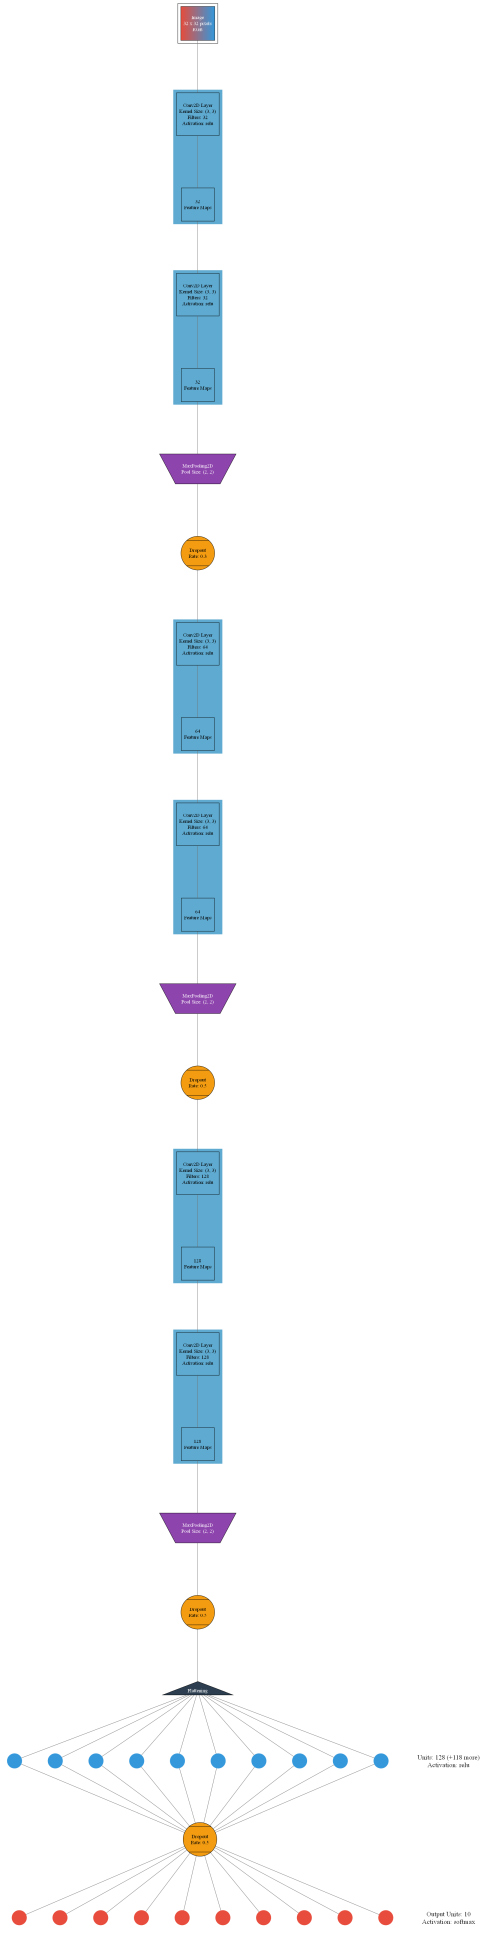

## Učení

Nastavíme parametry učení.

In [ ]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

Vytvoříme Earlystop, abychom zbytečně netrénovali již natrénovanou síť.

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=30)

Spustíme trénování sítě.

Trénování složitějšího modelu trvá déle, proto je počet epoch nastaven na 15.

Pro dosažení lepších výsledků je možné počet epoch zvýšit.

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=15, callbacks=[early_stop])

Natrénovanou síť uložíme do souboru pro pozdější použití.

In [ ]:
model.save('classification_model_cifar10.keras')

## Historie učení
Opět je dobré se podívat na proces učení, zda klesá hodnota nákladové funkce.

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.legend(loc="right")
plt.title('Loss, accuracy')
plt.ylabel('Loss, accuracy')
plt.xlabel('Počet epoch')
plt.show()

## Ověření modelu
Natrénovaný model musíme ověřit na trénovacích datech.

In [ ]:
model = keras.models.load_model('classification_model_cifar10.keras')

In [ ]:
y_pred = model.predict(X_test)

Porovnáme predikci se správnou odpovědí pro první obrázek.

In [ ]:
y_pred[0]

se správnou odpovědí.

In [ ]:
y_test[0]

Výsledek dostáváme jako vektor pravdědpobností. Proto jednu odpověď získáme vyhledáním maxima.

In [ ]:
y_pred_best_answer = np.argmax(y_pred, axis=-1)
y_pred_best_answer

Totéž provedeme s testovacími odpovědmi (realita).

Ideálně se obě pole rovnají.

In [ ]:
y_test_best_answer=np.argmax(y_test, axis=-1)
y_test_best_answer

Vykreslíme se confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cf_matrix=confusion_matrix(y_test_best_answer, y_pred_best_answer)
sns.heatmap(cf_matrix, annot=True)

Zobrazíme si hodnotící parametry
* Accuracy

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print (f"Loss function: {scores[0]}")
print (f"Accuracy: {scores[1]}")

Můžeme si zobrazit přesnosti pro jednotlivé třídy obrázků.

In [ ]:
class_correct, class_count = [0]*10, [0]*10

for i in range(y_test.shape[0]):    
    if (y_test_best_answer[i] == y_pred_best_answer[i]):
        class_correct[y_test_best_answer[i]] +=1
    class_count[y_test_best_answer[i]] += 1
    
for i in range(10):
    print (f"Accuracy for {class_names[i]}: {class_correct[i]/class_count[i]:.2%}") 

Zajimavé může být zobrazení špatných odpovědí.

In [ ]:
def show_wrong_predictions(X_test, Y_test, Y_pred, rows=5, cols=5):        
    idx = 0
    max_examples = rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows), constrained_layout=True)    
    for i in range(Y_test.shape[0]):    
        if (Y_test[i] != Y_pred[i]):                                    
            ridx=idx // cols
            cidx=idx % cols            
            ax = axes[ridx, cidx]
            ax.axis("off")
            ax.imshow(X_test[i].reshape(32,32,3), cmap="gray_r")
            ax.set_title(f"{class_names[Y_test[i]]} != {class_names[Y_pred[i]]}")
            idx +=1
            if (idx == max_examples):
                break

In [ ]:
show_wrong_predictions(X_test, y_test_best_answer, y_pred_best_answer, 2, 10)

# Konvoluční síť v pytorch
Vytvoříme stejnou síť pomocí frameworku pytorch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

## Načtení a příprava dat

Příprava funkce pro transformaci (normalizace + převod na tensor)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.ConvertImageDtype(torch.float32)   
])

Opět cifar10 je známý, takže v pytorch je jeho stažení zabudované.

In [ ]:
train_dataset = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

Při trénovaní na GPU je třeba data přenášet z paměti CPU do paměti GPU. Tato režie zpomaluje trénink. Je vhodné zvýšit objem, který se během cyklu přenáší. 

Proto byla zvětšila velikost batch na 1024. 

Při sledování zaplnění paměti GPU by šla tato hodnot i zvýšit.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1024)

## GPU
Ověření, zda je dostupné GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

## Model sítě

V modelu je již vidět, že síť se skládá ze dvou částí:
* konvoluční síť, která hledá features
* sekvenční sítě, která provádí klasifikaci podle nalezených features

Metoda forward postupně volá tyto dvě podsítě

In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Vytvoření sítě na její nahrání do GPU

In [ ]:
model = CIFAR10_CNN()
model.to(device)

## Parametry učení

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0
patience = 5
epochs_no_improve = 0
epochs = 50

history_loss = []
history_acc = []

## Učení

In [ ]:
for epoch in range(epochs):
    
    model.train()
    train_losses = []
    train_accs = []

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        preds = outputs.argmax(dim=1)
        acc = (preds == y_batch).float().mean().item()
        train_accs.append(acc)

    epoch_loss = np.mean(train_losses)
    epoch_acc = np.mean(train_accs)
    history_loss.append(epoch_loss)
    history_acc.append(epoch_acc)

    print(f"Epoch {epoch+1}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

model.load_state_dict(best_state)

## Historie učení

In [ ]:
plt.plot(history_loss, label="Train Loss")
plt.plot(history_acc, label="Train Accuracy")
plt.legend()
plt.title("Loss, Accuracy")
plt.show()

## Ověření modelu

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds)
        all_labels.append(y_batch)

y_pred_best_answer = torch.cat(all_preds).cpu().numpy()
y_test_best_answer = torch.cat(all_labels).cpu().numpy()

In [ ]:
acc = accuracy_score(y_test_best_answer, y_pred_best_answer)
print("Accuracy:", acc)

## Confusion matrix

In [ ]:
cf = confusion_matrix(y_test_best_answer, y_pred_best_answer)
sns.heatmap(cf, annot=True)
plt.show()

## Uložení modelu

In [ ]:
torch.save(model.state_dict(), "classification_cifar10_model.pt")

## Inference modelu

In [ ]:
model = CIFAR10_CNN()
model.load_state_dict(torch.load("classification_cifar10_model.pt"))
model.to(device)
model.eval()

Klasifikace jednoho obrázku

In [ ]:
sample = test_dataset[0][0].unsqueeze(0)

with torch.no_grad():
    sample = sample.to(device)
    logits = model(sample)
    probs = torch.softmax(logits, dim=1).cpu().numpy()

print("Probabilities:", probs)
print("Predicted class:", np.argmax(probs))

Přesnost určování jednotlivých tříd

In [ ]:
class_correct, class_count = [0]*10, [0]*10

for i in range(y_test.shape[0]):    
    if (y_test_best_answer[i] == y_pred_best_answer[i]):
        class_correct[y_test_best_answer[i]] +=1
    class_count[y_test_best_answer[i]] += 1
    
for i in range(10):
    print (f"Accuracy for {class_names[i]}: {class_correct[i]/class_count[i]:.2%}") 

Špatně určené obrázky

In [ ]:
show_wrong_predictions(X_test, y_test_best_answer, y_pred_best_answer, 2, 10)